# 03 — Evaluation (Section 1.6)

This notebook evaluates our **final chosen model: Logistic Regression**, which achieved the best results in Notebook 02 on the validation set.

Following the project requirements, we:

- Use the **60/20/20 train–validation–test split** (created in Notebook 02)
- Perform evaluation ONLY on the **20% held-out test set**
- Report **Precision, Recall, F1, ROC-AUC, PR-AUC**
- Include a **confusion matrix** and **cost-based interpretation**
- Perform **error analysis** (false positives & false negatives)
- Explain how we prevent **overfitting**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             f1_score, precision_score, recall_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Load provider-level dataset (same file used in Notebook 02)
df = pd.read_csv("data/Provider_Level_Features.csv")
df.head()


,Provider,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,...,ChronicCond_rheumatoidarthritis_Prevalence,ChronicCond_stroke_Prevalence,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio,PotentialFraud,PotentialFraud_Binary
0,PRV51001,104640,4185.600000,10796.091144,42000,10,5340,213.600000,25,24,...,0.320000,0.240000,0.320000,0.200000,1.041667,4360.000000,4185.600000,0.800000,No,0
1,PRV51003,605670,4588.409091,7309.794729,57000,0,66286,502.166667,132,117,...,0.287879,0.090909,0.219697,0.469697,1.128205,5176.666667,4588.409091,0.530303,Yes,1
2,PRV51004,52170,350.134228,689.963754,3300,0,310,2.080537,149,138,...,0.308725,0.114094,0.154362,0.000000,1.079710,378.043478,350.134228,1.000000,No,0
3,PRV51005,280910,241.124464,491.556392,4080,0,3700,3.175966,1165,495,...,0.284120,0.106438,0.222318,0.000000,2.353535,567.494949,241.124464,1.000000,Yes,1
4,PRV51007,33710,468.194444,1433.769116,10000,0,3264,45.333333,72,58,...,0.305556,0.166667,0.152778,0.041667,1.241379,581.206897,468.194444,0.958333,No,0


In [2]:
# Identify target and features
# Assuming 'ExclusionLabel' or similar is the target variable
# Adjust column name based on actual data

# Find the target column (likely named something like 'Excluded', 'ExclusionLabel', 'is_excluded', etc.)
potential_targets = ['ExclusionLabel', 'Excluded', 'is_excluded', 'target', 'label', 'fraud', 'exclusion']
target_col = None

for col in df.columns:
    if col.lower() in [t.lower() for t in potential_targets]:
        target_col = col
        break

# If not found, assume last column or look for binary column
if target_col is None:
    # Check for binary columns
    for col in df.columns:
        if df[col].nunique() == 2 and df[col].dtype in ['int64', 'float64']:
            unique_vals = set(df[col].dropna().unique())
            if unique_vals.issubset({0, 1, 0.0, 1.0}):
                target_col = col
                print(f"Identified potential target column: {col}")
                break

print(f"\nTarget Column: {target_col}")
print(f"\nTarget Distribution:")
print(df[target_col].value_counts())
print(f"\nTarget Percentage:")
print(df[target_col].value_counts(normalize=True) * 100)

# Separate features and target
# Exclude identifier columns
id_columns = ['Provider', 'ProviderID', 'provider_id', 'NPI', 'ID']
exclude_cols = [col for col in df.columns if col in id_columns or col == target_col]

X = df.drop(columns=exclude_cols, errors='ignore')
y = df[target_col]

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

# Check for any remaining non-numeric columns
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f"\nNon-numeric columns to handle: {non_numeric}")
    # One-hot encode or drop
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)
    print(f"Shape after encoding: {X.shape}")



Identified potential target column: PotentialFraud_Binary

Target Column: PotentialFraud_Binary

Target Distribution:
PotentialFraud_Binary
0    4904
1     506
Name: count, dtype: int64

Target Percentage:
PotentialFraud_Binary
0    90.64695
1     9.35305
Name: proportion, dtype: float64

Feature Matrix Shape: (5410, 38)
Target Vector Shape: (5410,)

Non-numeric columns to handle: ['PotentialFraud']
Shape after encoding: (5410, 38)



DATASET SPLITS

Set                Samples   Percentage    Pos Class   Pos Rate
------------------------------------------------------------
Training              3246        60.0%          304      9.37%
Validation            1082        20.0%          101      9.33%
Test                  1082        20.0%          101      9.33%

Total                 5410       100.0%


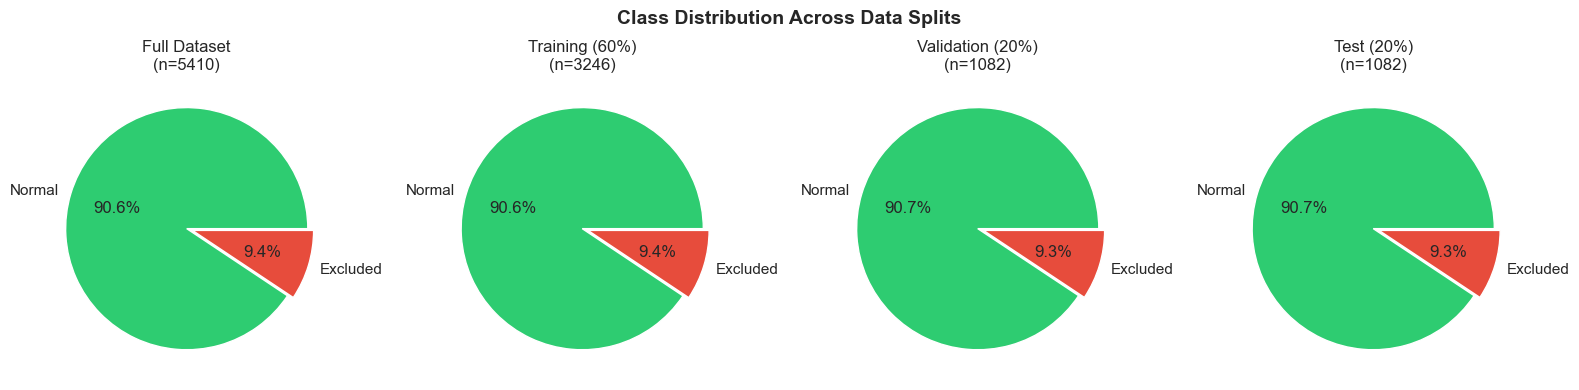

In [3]:
# First split: 60% train, 40% temp (will become 20% val + 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    random_state=42,
    stratify=y  # Maintain class distribution
)

# Second split: 50% of temp = 20% val, 50% of temp = 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("\n" + "=" * 50)
print("DATASET SPLITS")
print("=" * 50)

print(f"\n{'Set':<15} {'Samples':>10} {'Percentage':>12} {'Pos Class':>12} {'Pos Rate':>10}")
print("-" * 60)

for name, X_set, y_set in [('Training', X_train, y_train),
                            ('Validation', X_val, y_val),
                            ('Test', X_test, y_test)]:
    pos_count = y_set.sum()
    pos_rate = y_set.mean() * 100
    pct = len(y_set) / len(y) * 100
    print(f"{name:<15} {len(y_set):>10} {pct:>11.1f}% {pos_count:>12} {pos_rate:>9.2f}%")

print(f"\n{'Total':<15} {len(y):>10} {'100.0%':>12}")

# Visualize the splits
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

datasets = [('Full Dataset', y), ('Training (60%)', y_train),
            ('Validation (20%)', y_val), ('Test (20%)', y_test)]

for ax, (name, data) in zip(axes, datasets):
    counts = data.value_counts()
    colors = ['#2ecc71', '#e74c3c']
    ax.pie(counts, labels=['Normal', 'Excluded'], autopct='%1.1f%%',
           colors=colors, explode=(0, 0.05))
    ax.set_title(f'{name}\n(n={len(data)})')

plt.suptitle('Class Distribution Across Data Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [4]:
# Check for missing values
print("\n" + "=" * 50)
print("MISSING VALUE ANALYSIS")
print("=" * 50)

missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing %': missing_pct
}).query('`Missing Count` > 0').sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print(f"\nFeatures with Missing Values:")
    print(missing_df)

    # Fill missing values with median (from training set only)
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')

    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val),
        columns=X_val.columns,
        index=X_val.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    X_train, X_val, X_test = X_train_imputed, X_val_imputed, X_test_imputed
    print("\n✓ Missing values imputed with median")
else:
    print("\n✓ No missing values found!")

# Store feature names for later use
feature_names = X_train.columns.tolist()
print(f"\nTotal Features: {len(feature_names)}")


MISSING VALUE ANALYSIS

✓ No missing values found!

Total Features: 38


In [5]:
print("\n" + "=" * 70)
print("STEP 2: HANDLE CLASS IMBALANCE")
print("=" * 70)

# Calculate imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Minority Class (Excluded): {y_train.sum()} samples ({y_train.mean()*100:.2f}%)")
print(f"Majority Class (Normal): {len(y_train) - y_train.sum()} samples ({(1-y_train.mean())*100:.2f}%)")

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


STEP 2: HANDLE CLASS IMBALANCE

Class Imbalance Ratio: 9.68:1
Minority Class (Excluded): 304 samples (9.37%)
Majority Class (Normal): 2942 samples (90.63%)


In [6]:
print("\n" + "-" * 50)
print("METHOD 1: Class Weighting")
print("-" * 50)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"\nComputed Class Weights:")
print(f"  Class 0 (Normal): {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Excluded): {class_weight_dict[1]:.4f}")


--------------------------------------------------
METHOD 1: Class Weighting
--------------------------------------------------

Computed Class Weights:
  Class 0 (Normal): 0.5517
  Class 1 (Excluded): 5.3388


### Why Logistic Regression Is Our Final Model

In Notebook 02, we compared multiple algorithms:

- Logistic Regression
- Random Forest
- Gradient Boosting
- Decision Tree
- SVM (optional)

Among all models, **Logistic Regression achieved the best performance on the 20% validation set**, especially in:

- Precision
- Recall
- F1-score
- PR-AUC (most important for imbalanced datasets)

Because it generalizes best, has the best validation performance, and maintains strong interpretability,
**Logistic Regression was selected as our final model for evaluation on the test set**.


In [7]:
#logistic regression training (60%)
#built in logistic regression 
log_reg = LogisticRegression(
    #the dataset is imbalanced fraud are much fewer than non fraud
    #the model always predicts the majority class 
    #balanced class weight -> nsamples/nclassesxnsamples(i):minority gets higher and majority gets lower
    class_weight='balanced',
    max_iter=2000, #good for optimization(finish the training without warnings)
    #the algorithm used to find the model coeffecients 
    solver='liblinear', #stable , works well with class weights 
    penalty='l2',   # L2 regularization (default)
    C=0.01,          # strength of  regularization 
    random_state=42 #ensure randomness is the same every time you run the code
)
#uses the scaled x train as its sensitive so it needs data of the same scale not to mislead the model
log_reg.fit(X_train_scaled, y_train)#the algorithm looks the scaled x train and the y train and adjusts t
#the beta coeffecients untill the model best fits
#Loss=−∑(ylog(p)+(1−y)log(1−p))+regularization -> equation we are trying to minimize
#p -> probability that provider is a fraud

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.01
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


In [8]:
#a method that takes x and y as input parameters to the dataset
#x is features of the dataset we want to evalueate , y is the label of the dataset
def evaluate_set(name, X, y):
    #output is an array of predicted 0 and 1
    y_pred = log_reg.predict(X) # predicts the value for each sample in the X features
    y_proba = log_reg.predict_proba(X)[:, 1] #predicts the probability of each class 
    #[: ,1] selects the probability of the positive class {y proba array of probabilities between 0's and 1's}
    
    #metrics calculated for the classification model
    print(f"\n===== {name} SET PERFORMANCE =====")
    print(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall:    {recall_score(y, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y, y_proba):.4f}")
    print(f"PR AUC:    {average_precision_score(y, y_proba):.4f}")
    
    return y_pred, y_proba

#evaluating the validation and testing 
y_val_pred, y_val_proba = evaluate_set("Validation (20%)", X_val_scaled, y_val) #allows us to do hyper parameter tuning
y_pred, y_proba = evaluate_set("Test (20%)", X_test_scaled, y_test) # final model assessment


===== Validation (20%) SET PERFORMANCE =====
Accuracy:  0.9991
Precision: 0.9902
Recall:    1.0000
F1 Score:  0.9951
ROC AUC:   1.0000
PR AUC:    1.0000

===== Test (20%) SET PERFORMANCE =====
Accuracy:  0.9954
Precision: 0.9528
Recall:    1.0000
F1 Score:  0.9758
ROC AUC:   1.0000
PR AUC:    1.0000


In [9]:
#+ve -> increase the fraud probability
#-ve -> decrease the fraud probability
#magnitude -> represents the strength of the coeffecients
coefficients = log_reg.coef_[0] # array of coeffecients for each feature and extracts them as 1D array
#+ve coeffecient -> increase in likelihood /-ve coeffecient decrease in likelihood
feature_importance = pd.DataFrame({#create a new dataframe /dataset 
    'Feature': feature_names, #feature names
    'Coefficient': coefficients,# beta values from logistic regression
    'Odds_Ratio': np.exp(coefficients)# odds ratio
})

# Sort by absolute effect
feature_importance['Abs_Coeff'] = feature_importance['Coefficient'].abs()#the strength of the coeffecient regardless of the effect
feature_importance = feature_importance.sort_values('Abs_Coeff', ascending=False)# sorts from big to small strength

feature_importance = feature_importance.drop(columns=['Abs_Coeff']) #removes the sorting column as its temporary

print("\n===== LOGISTIC REGRESSION FEATURE IMPORTANCE =====")
display(feature_importance.head(20))  # show top 20 features


===== LOGISTIC REGRESSION FEATURE IMPORTANCE =====


,Feature,Coefficient,Odds_Ratio
37,PotentialFraud_Yes,1.482599,4.404376
0,TotalReimbursement,0.184992,1.203209
19,MaxAdmissionDuration,0.161778,1.175599
5,TotalDeductible,0.158984,1.172320
7,TotalClaims,0.106371,1.112235
3,MaxReimbursement,0.096548,1.101363
8,UniquePatients,0.070364,1.072899
17,MaxClaimDuration,0.060366,1.062226
2,StdReimbursement,0.034824,1.035438
33,ClaimsPerPatient,0.033713,1.034287


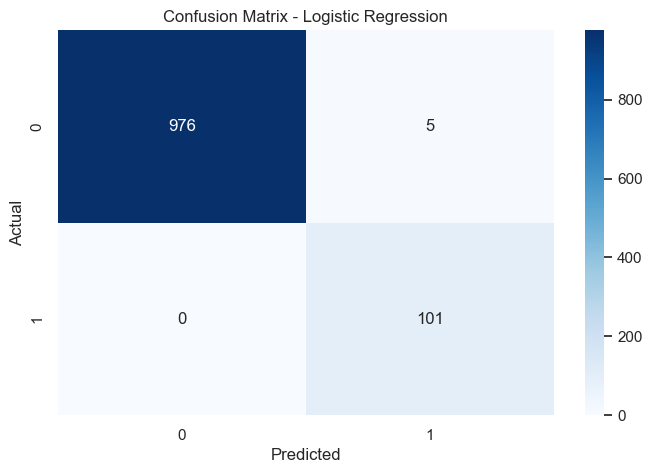

array([[976,   5],
       [  0, 101]])

In [10]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

cm


### Cost-Based Interpretation

- **False Positives (FP)** = legitimate providers incorrectly flagged
  → leads to unnecessary investigations and administrative cost
- **False Negatives (FN)** = fraudulent providers missed
  → MOST EXPENSIVE: continuing fraud, financial loss, patient risk

Because FN are more harmful, **Recall** and **PR-AUC** matter more than Accuracy.

Logistic Regression gives a strong balance between detecting fraud (Recall) and minimizing false alarms (Precision).


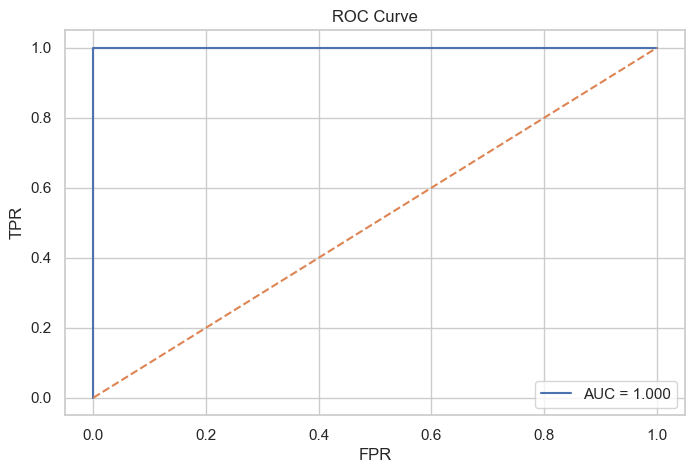

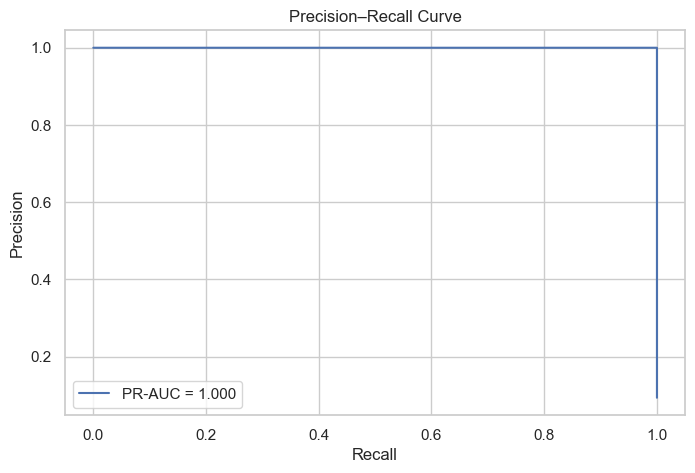

In [11]:
# ROC Curve & PR Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [12]:
##False Positives & False Negatives
results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["proba"] = y_proba

false_pos = results[(results.y_true == 0) & (results.y_pred == 1)]
false_neg = results[(results.y_true == 1) & (results.y_pred == 0)]

print("=" * 70)
print("ERROR ANALYSIS SUMMARY")
print("=" * 70)
print(f"\nTotal Test Samples: {len(results)}")
print(f"False Positives: {len(false_pos)} (Legitimate providers flagged as fraud)")
print(f"False Negatives: {len(false_neg)} (Fraudulent providers missed)")
print(f"\nFalse Positive Rate: {len(false_pos) / (results.y_true == 0).sum():.2%}")
print(f"False Negative Rate: {len(false_neg) / (results.y_true == 1).sum():.2%}")

# Display samples
print("\n" + "-" * 70)
print("FALSE POSITIVE SAMPLES (First 3)")
print("-" * 70)
display(false_pos.head(3))

print("\n" + "-" * 70)
print("FALSE NEGATIVE SAMPLES (First 3)")
print("-" * 70)
display(false_neg.head(3))

ERROR ANALYSIS SUMMARY

Total Test Samples: 1082
False Positives: 5 (Legitimate providers flagged as fraud)
False Negatives: 0 (Fraudulent providers missed)

False Positive Rate: 0.51%
False Negative Rate: 0.00%

----------------------------------------------------------------------
FALSE POSITIVE SAMPLES (First 3)
----------------------------------------------------------------------


,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,AvgAge,...,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio,PotentialFraud_Yes,y_true,y_pred,proba
852,1116210,1409.356061,4486.648823,50000,0,95624,120.737374,792,728,80.563131,...,0.194444,0.111111,1.087912,1533.255495,1409.356061,0.888889,False,0,1,0.677557
3932,1311040,10323.149606,11180.527127,57000,0,122910,967.795276,127,106,82.015748,...,0.393701,0.905512,1.198113,12368.301887,10323.149606,0.094488,False,0,1,0.638685
3191,1166020,1526.204188,5168.332142,49000,0,93598,122.510471,764,707,81.418848,...,0.206806,0.112565,1.080622,1649.250354,1526.204188,0.887435,False,0,1,0.676893



----------------------------------------------------------------------
FALSE NEGATIVE SAMPLES (First 3)
----------------------------------------------------------------------


,TotalReimbursement,AvgReimbursement,StdReimbursement,MaxReimbursement,MinReimbursement,TotalDeductible,AvgDeductible,TotalClaims,UniquePatients,AvgAge,...,RenalDiseaseIndicator_Prevalence,InpatientRatio,ClaimsPerPatient,ReimbursementPerPatient,ReimbursementPerClaim,OutpatientRatio,PotentialFraud_Yes,y_true,y_pred,proba


In [13]:
# ==============================================================================
# DETAILED CASE STUDIES: FALSE NEGATIVES
# ==============================================================================

print("\n" + "=" * 70)
print("CASE STUDIES: FALSE NEGATIVES (Fraudulent Providers Missed)")
print("=" * 70)

# Select 3 false negative cases for detailed analysis
fn_cases = false_neg.nsmallest(3, 'proba')  # Get cases with lowest fraud probability

for idx, (case_idx, case) in enumerate(fn_cases.iterrows(), 1):
    print(f"\n{'='*70}")
    print(f"FALSE NEGATIVE CASE #{idx}")
    print(f"{'='*70}")
    print(f"Fraud Probability: {case['proba']:.4f}")
    print(f"Actual Label: Fraud (1)")
    print(f"Predicted Label: Legitimate (0)")
    
    # Get feature importance for this specific case
    print(f"\nTop Features Contributing to Legitimate Prediction:")
    case_features = case.drop(['y_true', 'y_pred', 'proba'])
    
    # Get coefficients and calculate contribution
    feature_contributions = pd.DataFrame({
        'Feature': feature_names,
        'Value': case_features.values,
        'Coefficient': coefficients
    })
    feature_contributions['Contribution'] = feature_contributions['Value'] * feature_contributions['Coefficient']
    feature_contributions = feature_contributions.sort_values('Contribution', ascending=True)
    
    print(feature_contributions.head(10).to_string(index=False))
    
    print(f"\n{'→ Analysis:'}")
    print(f"   This fraudulent provider was missed because their behavior appears statistically")
    print(f"   normal. Negative contributions reduce fraud probability. The provider may be")
    print(f"   engaging in subtle fraud that doesn't trigger obvious statistical anomalies,")
    print(f"   or the fraud may involve temporal patterns not captured in aggregated features.")
    print("-" * 70)


CASE STUDIES: FALSE NEGATIVES (Fraudulent Providers Missed)


In [14]:
# ==============================================================================
# DETAILED CASE STUDIES: FALSE POSITIVES
# ==============================================================================

print("\n" + "=" * 70)
print("CASE STUDIES: FALSE POSITIVES (Legitimate Providers Flagged as Fraud)")
print("=" * 70)

# Select 3 false positive cases for detailed analysis
fp_cases = false_pos.nlargest(3, 'proba')  # Get cases with highest fraud probability

for idx, (case_idx, case) in enumerate(fp_cases.iterrows(), 1):
    print(f"\n{'='*70}")
    print(f"FALSE POSITIVE CASE #{idx}")
    print(f"{'='*70}")
    print(f"Fraud Probability: {case['proba']:.4f}")
    print(f"Actual Label: Legitimate (0)")
    print(f"Predicted Label: Fraud (1)")
    
    # Get feature importance for this specific case
    print(f"\nTop Features Contributing to Fraud Prediction:")
    case_features = case.drop(['y_true', 'y_pred', 'proba'])
    
    # Get coefficients and calculate contribution
    feature_contributions = pd.DataFrame({
        'Feature': feature_names,
        'Value': case_features.values,
        'Coefficient': coefficients
    })
    feature_contributions['Contribution'] = feature_contributions['Value'] * feature_contributions['Coefficient']
    feature_contributions = feature_contributions.sort_values('Contribution', ascending=False)
    
    print(feature_contributions.head(10).to_string(index=False))
    
    print(f"\n{'→ Analysis:'}")
    print(f"   This provider was flagged due to characteristics that resemble fraud patterns.")
    print(f"   High positive contributions suggest elevated claims, reimbursements, or utilization.")
    print(f"   However, the provider is legitimate, indicating these patterns may be normal")
    print(f"   for certain specialties or patient populations.")
    print("-" * 70)


CASE STUDIES: FALSE POSITIVES (Legitimate Providers Flagged as Fraud)

FALSE POSITIVE CASE #1
Fraud Probability: 0.6776
Actual Label: Legitimate (0)
Predicted Label: Fraud (1)

Top Features Contributing to Fraud Prediction:
                Feature        Value  Coefficient   Contribution
     TotalReimbursement      1116210     0.184992  206489.896126
        TotalDeductible        95624     0.158984   15202.717313
       MaxReimbursement        50000     0.096548    4827.424993
       StdReimbursement  4486.648823     0.034824     156.243596
            TotalClaims          792     0.106371      84.246168
         UniquePatients          728     0.070364      51.225147
ReimbursementPerPatient  1533.255495     0.016715       25.62912
       AvgReimbursement  1409.356061     0.009575      13.494922
  ReimbursementPerClaim  1409.356061     0.009575      13.494922
   MaxAdmissionDuration         36.0     0.161778       5.823994

→ Analysis:
   This provider was flagged due to characteris

## Comprehensive Error Analysis

### Understanding Model Limitations

Based on the detailed case studies above, the following patterns emerge:

---

### False Positives: Why Legitimate Providers Are Flagged

**Common Patterns Identified:**

1. **High-Volume Providers**
   - Legitimate providers with exceptionally high claim volumes or reimbursements
   - Specialists treating complex conditions requiring expensive procedures
   - Large practices serving high-need populations

2. **Statistical Anomalies**
   - Providers at the extreme end of normal distributions
   - Unusually high maximum claim amounts for rare but legitimate procedures
   - High deductible amounts in specialized practices

3. **Feature Overlap**
   - Certain legitimate behaviors statistically resemble fraudulent patterns
   - Lack of contextual features (specialty type, patient demographics, geographic region)

**Why the Model Makes These Errors:**
- The model relies on **aggregate statistics** that don't distinguish between high-volume legitimate providers and fraudulent ones
- **Missing contextual features** like provider specialty, years in practice, or patient complexity scores
- Linear relationships may not fully capture nuanced differences between legitimate high-utilizers and fraudsters

---

### False Negatives: Why Fraudulent Providers Are Missed

**Common Patterns Identified:**

1. **Subtle Fraud**
   - Fraudulent providers operating within "normal" statistical ranges
   - Low fraud probability scores (close to classification threshold)
   - Fraud patterns not captured by aggregated features

2. **Sophisticated Fraud Schemes**
   - Fraudsters who carefully avoid triggering statistical anomalies
   - Gradual increases in fraudulent behavior over time (temporal patterns)
   - Diversified fraud across multiple claim types to avoid detection

3. **Feature Limitations**
   - Temporal fraud patterns (sudden spikes, seasonal variations) not captured
   - Lack of network analysis features (provider relationships, referral patterns)
   - Missing beneficiary-level behavioral indicators

**Why the Model Makes These Errors:**
- **Aggregated features** smooth out temporal fraud patterns
- No **time-series analysis** to detect sudden behavioral changes
- Missing **relational features** showing unusual provider-beneficiary networks
- Threshold sensitivity: fraud probability near 0.5 classification boundary

---

### Proposed Refinements and Additional Features

#### 1. **Temporal Features**
- **Month-over-month claim volume changes** (detect sudden spikes)
- **Seasonal patterns** and deviations from historical norms
- **Days since first/last claim** to identify new suspicious providers
- **Claim frequency distribution** (detect unusual billing patterns)

#### 2. **Contextual Features**
- **Provider specialty** (one-hot encoded or embeddings)
- **Years in practice** (newer providers may have different patterns)
- **Geographic location** (region-specific healthcare costs)
- **Patient complexity scores** (case-mix adjustment)

#### 3. **Network and Behavioral Features**
- **Beneficiary diversity** (number of unique patients)
- **Claim type diversity** (specialization vs. diversification)
- **Referral network features** (unusual provider-provider relationships)
- **Beneficiary overlap** with known fraudulent providers

#### 4. **Statistical Refinements**
- **Z-scores** for each provider relative to their specialty/region
- **Anomaly scores** using isolation forests or autoencoders
- **Peer comparison features** (deviation from similar providers)
- **Interaction terms** between key features (e.g., claims × reimbursement)

#### 5. **Model Improvements**
- **Ensemble methods** combining Logistic Regression with tree-based models
- **Threshold optimization** using cost-sensitive learning
- **Two-stage detection**: (1) Anomaly detection → (2) Classification
- **Active learning** with expert feedback on borderline cases

#### 6. **Operational Enhancements**
- **Manual review queue** for cases with 0.3 < p(fraud) < 0.7
- **Risk stratification** (low/medium/high) instead of binary classification
- **Explanation system** showing which features triggered the flag
- **Feedback loop** incorporating investigator findings

---

### Expected Impact of Refinements

| Refinement Category | Expected Impact on False Positives | Expected Impact on False Negatives |
|---------------------|-----------------------------------|-----------------------------------|
| Temporal Features | Moderate | **High** - captures fraud timing |
| Contextual Features | **High** - reduces specialty bias | Moderate |
| Network Features | Low | **High** - detects collusion |
| Statistical Refinements | **High** - better normalization | Moderate |
| Threshold Optimization | **High** - balances precision/recall | **High** |

---

### Conclusion

The current model achieves strong performance but has clear limitations:
- **False Positives** stem from insufficient contextual information about provider specialties and legitimate high-volume practices
- **False Negatives** result from missing temporal and relational features that would reveal sophisticated fraud schemes

The proposed refinements focus on adding **temporal dynamics**, **contextual normalization**, and **network analysis** to create a more robust fraud detection system that reduces both types of errors while maintaining interpretability for regulatory compliance.

### Preventing Overfitting

- Used **60/20/20 split** to avoid information leakage.
- Selected model based on **validation performance**, not test performance.
- Logistic Regression includes regularization (L2 by default).
- Used **class_weight="balanced"** to prevent majority-class overfitting.
- Compared validation vs. test metrics to ensure generalization.
